In [12]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [13]:
%load_ext autoreload
%autoreload 2
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_class_path, HELMConverter
from node import MolSentenceNode #TODO: change after Filter implementation <- ?
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_path, model_dir, lang_class_path, lang_path = (conf.get(k) for k in ("model_class_path", "model_dir", "lang_class_path", "lang_path"))
lang_class = get_class_from_class_path(lang_class_path)
lang = lang_class.load(repo_root + lang_path)
if lang_class_path.endswith("HELM"): #TODO: should be removed after .lang inclusion
    lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_class_path(model_class_path)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_path, reward_conf = (conf.get(k) for k in ("reward_class_path", "reward_conf"))
reward_class = get_class_from_class_path(reward_class_path)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_path", "policy_conf"))
policy_class = get_class_from_class_path(policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_class_path(s.get("filter_class_path"))
    filters.append(filter_class(**s.get("filter_conf", {})))

Search is started.
0- time: 0.24, count_rollouts: 2, reward: 0.23145852109134438, node: O=C1CCCC[C@@H]1NC(=O)C(=O)N(C)C(C)Cc1ccc(Cl)cc1
1- time: 0.41, count_rollouts: 3, reward: 0.36014978552427285, node: N#Cc1ccc(OC(=O)Nc2ccc(OC(F)F)cc2)cc1
2- time: 0.59, count_rollouts: 4, reward: 0.017718145549034777, node: c1cccc(-n2nnc(OCC(=O)NCC)n2)c1
3- time: 1.02, count_rollouts: 7, reward: 0.3504441518914077, node: Clc1ccc(CN(C)C(=O)c2ccc([N+](=O)[O-])cc2F)cc1
4- time: 1.57, count_rollouts: 10, reward: 0.29417345895795044, node: [C@H]COc1ccc(Cl)cc1OC(F)F
5- time: 1.81, count_rollouts: 12, reward: 0.06639219063350084, node: [O-]c1cc(C(=O)NCCn2cccn2)cc(F)c1F
6- time: 2.13, count_rollouts: 14, reward: 0.3633152234775364, node: Clc1nc(-c2ccc(Br)cc2)n2ccccn2c1
7- time: 2.24, count_rollouts: 15, reward: 0.027711902948334567, node: [C@H]COC(=O)[C@@H]1COCC1
8- time: 2.47, count_rollouts: 17, reward: 0.12493383552469264, node: O=C1CN(CC2CN(C(=O)c3ccc(Cl)cc3)CC2=O)CC1
9- time: 2.62, count_rollouts: 18, 

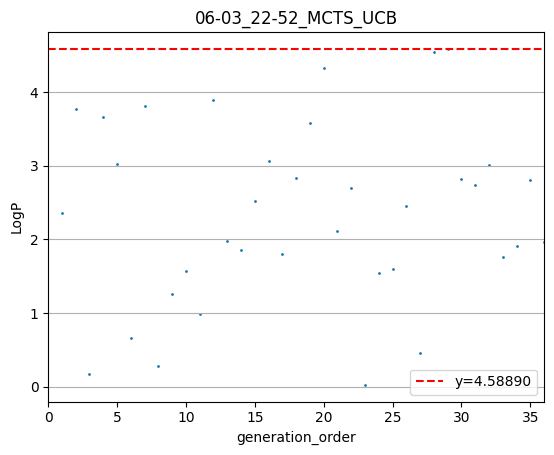

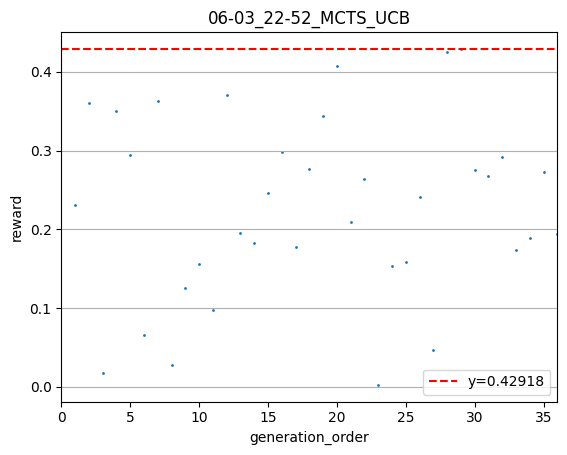

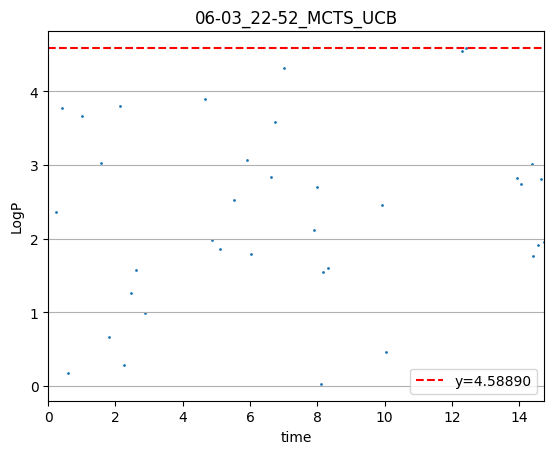

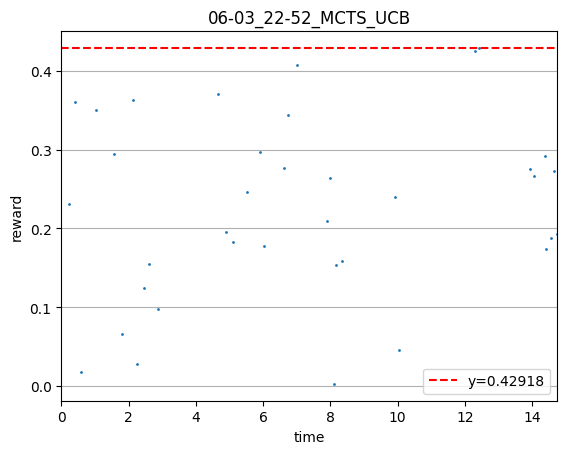

Search is completed.


In [26]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang)

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)